# Assignment 7 - Detect computer security breach using RNNs and LSTMs

# PART A: Recurrent Neural Network & Classification: 

The objective is to detect the security breach by predicting suspicious access using an RNN model and the provided Logfile data.

Logfile data includes login information like LogID, Timestamp, Method, Path, Status Code, Source, Remote Address, User Agent etc. The last indicator in each row denotes breach(1) and no breach(0) which is the target variable.

The expectation is that you will use the keras package to solve this problem (https://keras.io/ Links to an external site.). 

Data for HW: dev-access.csv Download dev-access.csv

# 1. Data Processing: This data set is a bit messy, so the preprocessing portion is largely a tutorial to make sure students have data ready for keras.
a) Import the following libraries: 



In [1]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import json
import pandas
import numpy
import optparse
import tensorflow as tf


from keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict


2024-05-09 14:55:30.434659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


b) We will read the code in slightly differently than before: 

c) We then need to convert to a numpy.ndarray type: 

d) Check the shape of the data set - it should be (26773, 2). Spend some time looking at the data. 



In [3]:
dataframe = pandas.read_csv("dev-access.csv", engine='python', quotechar='|', header=None)


In [4]:
dataset = dataframe.values
dataset.shape

(26773, 2)

e) Store all rows and the 0th index as the feature data: 

f) Store all rows and index 1 as the target variable: 



In [5]:
X = dataset[:,0]
Y = dataset[:,1]


g) In the next step, we will clean up the predictors. This includes removing features that are not valuable, such as timestamp and source. 



In [6]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

h) We next will tokenize our data, which just means vectorizing our text. Given the data we will tokenize every character (thus char_level = True)



In [7]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

i) Need to pad our data as each observation has a different length



In [8]:
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)

j) Create your train set to be 75% of the data and your test set to be 25%



In [9]:
from sklearn.model_selection import train_test_split

# Create training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", Y_train.shape)
print("Test target shape:", Y_test.shape)


Training set shape: (20079, 1024)
Test set shape: (6694, 1024)
Training target shape: (20079,)
Test target shape: (6694,)


# 2. Model 1 - RNN: The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers. 

a) Start by creating an instance of a Sequential model: https://keras.io/getting-started/sequential-model-guide/ Links to an external site.

b) From there, add an Embedding layer: https://keras.io/layers/embeddings/ Links to an external site.



In [17]:
# Convert feature arrays to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# If Y needs to be in float32 (optional, usually needed for regression tasks)
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')


In [18]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Embedding, SimpleRNN, Dense

# a) start by creating an Embedding layer
model= Sequential()

# b) add an Embedding layer

model.add(Embedding(input_dim=num_words,    # Number of words in the vocabulary
                    output_dim=32,         # Dimension of the dense embedding
                    input_length=max_log_length))  # Length of input sequences


c) Add a SimpleRNN layer: https://keras.io/layers/recurrent/ Links to an external site.

Params:
- units = 32
- activation = 'relu'

d) Finally, we will add a Dense layer: https://keras.io/layers/core/#dense Links to an external site.

Params:
- units = 1 (this will be our output)
- activation --> you can choose to use either relu or sigmoid. 

e) Compile model using the .compile() method: https://keras.io/models/model/ Links to an external site.

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

f) Print the model summary



In [19]:

# c) Add a SimpleRNN layer
model.add(SimpleRNN(32, activation='relu'))  # Units in RNN and activation function

# d) Add a Dense layer
model.add(Dense(1, activation='sigmoid'))  # Units in output layer and activation function

# e) Compile the model
model.compile(loss='binary_crossentropy',  # Loss function
              optimizer='adam',             # Optimizer
              metrics=['accuracy'])         # List of metrics

# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

g) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

h) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.



In [20]:
# g) Fit the model on the training data
history = model.fit(X_train, Y_train, 
                    validation_split=0.25,  # 25% of training data used for validation
                    epochs=3,               # Number of epochs
                    batch_size=128,         # Batch size for training
                    verbose=1)              # Show progress

# h) Evaluate the model on the test data to get the loss and accuracy
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.5704 - loss: 0.8387 - val_accuracy: 0.6171 - val_loss: 0.6241
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 325ms/step - accuracy: 0.6184 - loss: 0.6226 - val_accuracy: 0.6112 - val_loss: 0.6135
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.6080 - loss: 0.6140 - val_accuracy: 0.6112 - val_loss: 0.6100
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.6315 - loss: 0.6016
Test loss: 0.6064279675483704
Test accuracy: 0.6260830760002136


# 3) Model 2 - LSTM + Dropout Layers:

Now we will add a few new layers to our RNN and incorporate the more powerful LSTM. You will be creating a new model here, so make sure to call it something different than the model from Part 2.

a) This RNN needs to have the following layers (add in this order):

- Embedding Layer (use same params as before)
- LSTM Layer (units = 64, recurrent_dropout = 0.5)
- Dropout Layer - use a value of 0.5 
- Dense Layer - (use same params as before)

b) Compile model using the .compile() method:

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

c) Print the model summary

In [23]:
from keras.layers import LSTM, Dropout

lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length))

# Add an LSTM layer with recurrent dropout
lstm_model.add(LSTM(64, recurrent_dropout=0.5))

# Add a Dropout layer
lstm_model.add(Dropout(0.5))

# Add a Dense output layer (same parameters as before)
lstm_model.add(Dense(1, activation='sigmoid'))

# b) Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# c) Print the model summary
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.



In [24]:
# d) Fit the model on the training data
lstm_history = lstm_model.fit(X_train, Y_train,
                              validation_split=0.25,  # 25% of training data for validation
                              epochs=3,               # Number of epochs
                              batch_size=128,         # Batch size
                              verbose=1)              # Show progress

# e) Evaluate the model on the test data
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, Y_test, batch_size=128)
print("LSTM Model Test loss:", lstm_loss)
print("LSTM Model Test accuracy:", lstm_accuracy)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.6129 - loss: 0.6405 - val_accuracy: 0.9476 - val_loss: 0.2099
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8869 - loss: 0.3215 - val_accuracy: 0.9556 - val_loss: 0.1988
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9382 - loss: 0.2053 - val_accuracy: 0.9683 - val_loss: 0.1455
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - accuracy: 0.9670 - loss: 0.1472
LSTM Model Test loss: 0.1457221359014511
LSTM Model Test accuracy: 0.9681804776191711


# 4) Recurrent Neural Net Model 3: Build Your Own

You wil now create your RNN based on what you have learned from Model 1 & Model 2:

a) RNN Requirements: 
- Use 5 or more layers
- Add a layer that was not utilized in Model 1 or Model 2 (Note: This could be a new Dense layer or an additional LSTM)

b) Compiler Requirements: 
- Try a new optimizer for the compile step
- Keep accuracy as a metric (feel free to add more metrics if desired)

c) Print the model summary

d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [27]:
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# Initialize the model
complex_rnn_model = Sequential()

# Embedding layer
complex_rnn_model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length))

# First LSTM layer
complex_rnn_model.add(LSTM(64, return_sequences=True))
complex_rnn_model.add(Dropout(0.5))

# Second LSTM layer
complex_rnn_model.add(LSTM(32))
complex_rnn_model.add(Dropout(0.5))

# Intermediate Dense layer
complex_rnn_model.add(Dense(64, activation='relu'))

# Output Dense layer
complex_rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer
complex_rnn_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(),
                          metrics=['accuracy'])
# Print the model summary
complex_rnn_model.summary()

# Ensure data types are correct
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

# Fit the model on the training data
history = complex_rnn_model.fit(X_train, Y_train,
                                validation_split=0.25,
                                epochs=3,
                                batch_size=128,
                                verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = complex_rnn_model.evaluate(X_test, Y_test, batch_size=128)
print("Complex RNN Model Test loss:", test_loss)
print("Complex RNN Model Test accuracy:", test_accuracy)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.5740 - loss: 0.6719 - val_accuracy: 0.6367 - val_loss: 0.5915
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7997 - loss: 0.4411 - val_accuracy: 0.9209 - val_loss: 0.2299
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9030 - loss: 0.2796 - val_accuracy: 0.9721 - val_loss: 0.1049
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 716ms/step - accuracy: 0.9697 - loss: 0.1141
Complex RNN Model Test loss: 0.11493722349405289
Complex RNN Model Test accuracy: 0.9689273834228516


# Conceptual Questions: 

## 5) Explain the difference between the relu activation function and the sigmoid activation function.u

- **Rectified Linear Unit(rel): if input is less than 0, output=0, ifelse, output is input itself.**
- Usage: relu us used in hidden layers of neural networkd due to its ability to reduce the likelihood of vanishing gradient problem.  This problem occurs when gradients are backpropagated through the network and become so small that learning effectively stops.
- **sigmoid: can help normalize the data btw 0 t0 1. **
- Usage: useful in the output layer of a binary classification network, where we need a probability to decide between two classes.

## 6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).
 
- **Epoch : one complete pass throught the entire training dataset.ex) going through all the cards you have. **
- The more epochs, the more times the model has to learn from the data, but too many epochs can make the model memorize the data too well, leading to what’s called overfitting 

## 7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.

- During testing : randomly skipping a portion of features to generalize better and not overfit the traning data
- During testing: When evaluating the model, we don’t use dropout. 

## 8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?

- **RNNs are better where order and context matter a lot.** ex) predicting the next word in a sentence,it matters what the previous words were.
- **CNNs excel where the position and chracteristics of the data are more important that the sequence**. ex) recognizing objects in a pic.

## 9) Explain what RNN problem is solved using LSTM and briefly describe how.

- LSTM is a type of RNN that are better rembering information for a longer time. - - They have a special way of deciding what to remember and what to forget, which is like having a smarter notebook that keeps track of what’s important to remember for the exams and what can be safely forgotten. This helps them perform much better on tasks where understanding the entire context is crucial, like translating languages or predicting full sentences based on context.



# PART B: Time Series with LSTMs

Use the data DAYTON_hourly.csv Download DAYTON_hourly.csv

1. Import, clean and plot the input data
2. Train test split (use provided helper function helper.py Download helper.py, as we can’t use sklearn’s for time series data)
3. Fit a single layer LSTM with lag = 3 hours
4. Fit a single layer LSTM with lag = 24 hours
5. Fit a bidirectional LSTM with lag = 24 hours
6. Plot results on test set and compare performance using RMSE

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('DAYTON_hourly.csv')
data.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


              Datetime  DAYTON_MW
0  2004-12-31 01:00:00     1596.0
1  2004-12-31 02:00:00     1517.0
2  2004-12-31 03:00:00     1486.0
3  2004-12-31 04:00:00     1469.0
4  2004-12-31 05:00:00     1472.0
Datetime     0
DAYTON_MW    0
dtype: int64


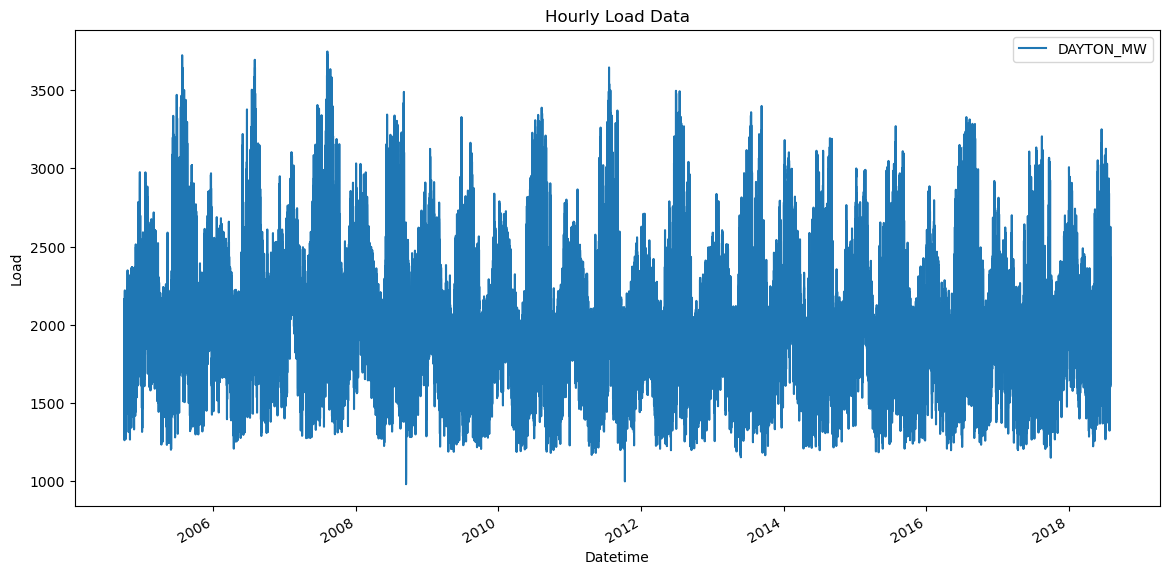

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('DAYTON_hourly.csv')
print(data.head())  # Inspect the first few rows of the dataset

# Check for missing values
print(data.isnull().sum())  # Print the number of missing values in each column

# Assuming 'Datetime' and 'Load' are columns in the CSV
data['Datetime'] = pd.to_datetime(data['Datetime'])  # Convert the Datetime column to datetime objects
data.set_index('Datetime', inplace=True)  # Set the Datetime column as the index

# Plotting the data
data.plot(figsize=(14, 7))
plt.title('Hourly Load Data')
plt.ylabel('Load')
plt.show()


In [47]:
# Prepare data
lag_3 = 3
lag_24 = 24
test_ratio = 0.2

X_train_3, X_test_3, Y_train_3, Y_test_3 = create_data_for_NN(data,'DAYTON_MW', lag_3, test_ratio)
X_train_24, X_test_24, Y_train_24, Y_test_24 = create_data_for_NN(data, 'DAYTON_MW', lag_24, test_ratio)

# Build LSTM models
def build_lstm_model(input_shape, units=50, bidirectional=False):
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(units), input_shape=input_shape))
    else:
        model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training models
model_3 = build_lstm_model((lag_3, 1))
model_24 = build_lstm_model((lag_24, 1))
model_bidirectional = build_lstm_model((lag_24, 1), bidirectional=True)

model_3.fit(X_train_3, Y_train_3, epochs=10, batch_size=32)
model_24.fit(X_train_24, Y_train_24, epochs=10, batch_size=32)
model_bidirectional.fit(X_train_24, Y_train_24, epochs=10, batch_size=32)


/Users/colleenjung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 4299835.5000
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4079669.0000
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 3871517.5000
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3666209.5000
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3475052.7500
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3283575.0000
Epoch 7/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3094096.7500
Epoch 8/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2930593.0000
Epoch 9/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2746416.2500
Epoch 10/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2588877.2500
Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 4276508.5000
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 4025361.7500
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 3783890.2500
Epoch 4/10
30

NameError: name 'mean_squared_error' is not defined

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import mean_squared_error

758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
RMSE 3-hour lag: 1524.2839998957616
RMSE 24-hour lag: 1428.0147578215697
RMSE Bidirectional 24-hour lag: 1281.2302074997485
758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


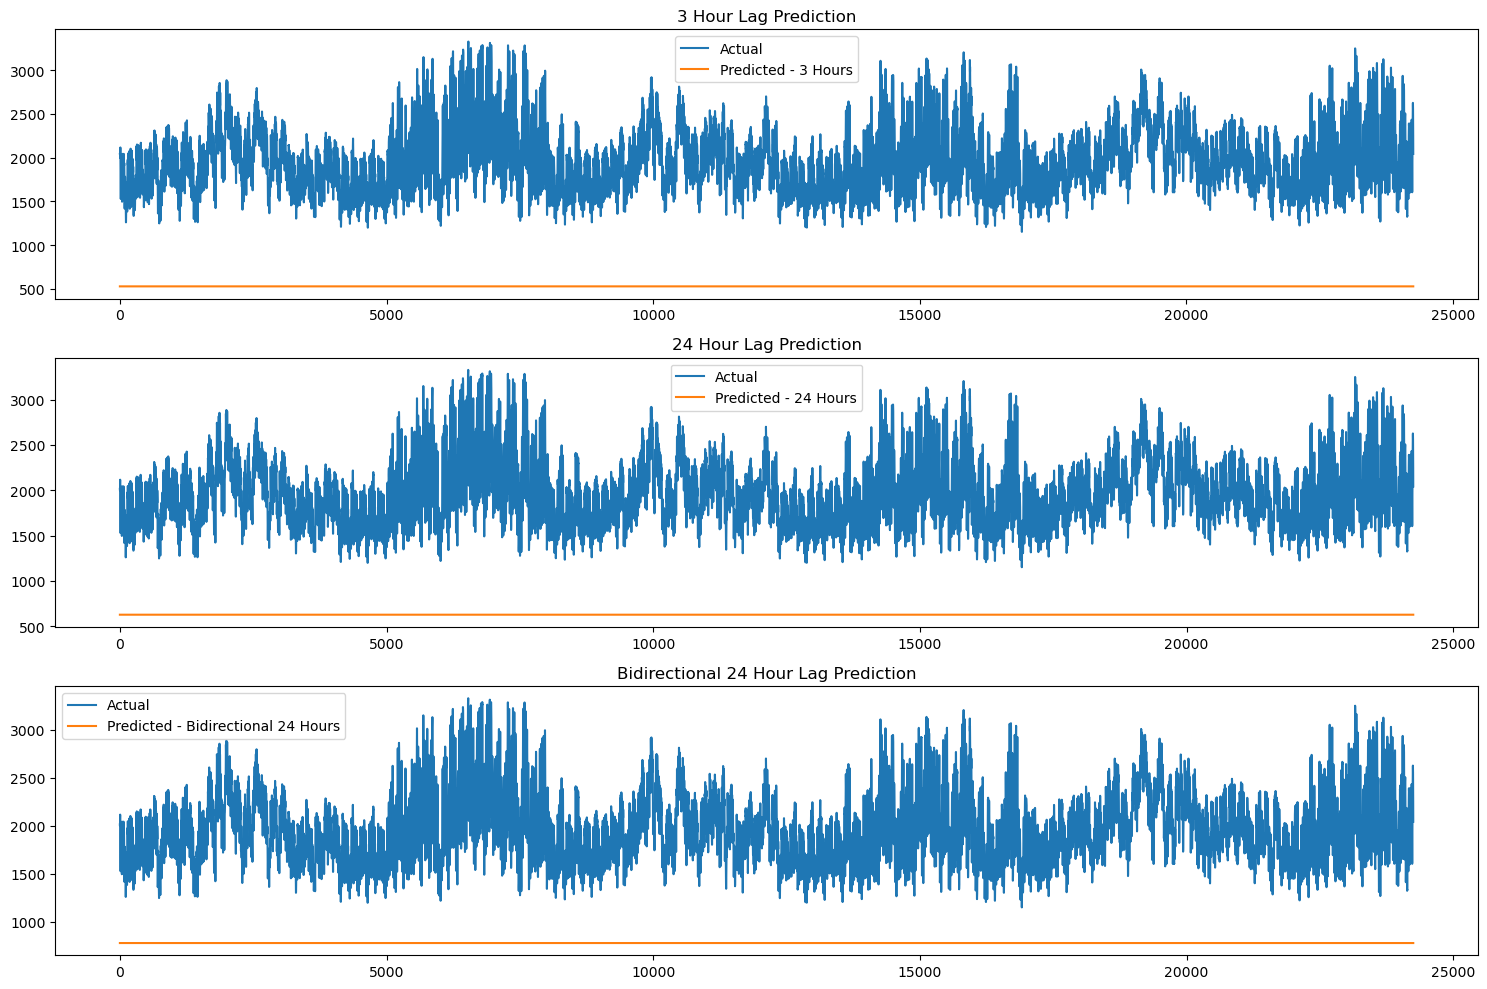

In [49]:

# Evaluate models
def evaluate_model(model, X_test, Y_test):
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(Y_test, predictions))

rmse_3 = evaluate_model(model_3, X_test_3, Y_test_3)
rmse_24 = evaluate_model(model_24, X_test_24, Y_test_24)
rmse_bidirectional = evaluate_model(model_bidirectional, X_test_24, Y_test_24)

print("RMSE 3-hour lag:", rmse_3)
print("RMSE 24-hour lag:", rmse_24)
print("RMSE Bidirectional 24-hour lag:", rmse_bidirectional)

# Plotting results
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.plot(Y_test_3, label='Actual')
plt.plot(model_3.predict(X_test_3), label='Predicted - 3 Hours')
plt.title('3 Hour Lag Prediction')
plt.legend()

plt.subplot(312)
plt.plot(Y_test_24, label='Actual')
plt.plot(model_24.predict(X_test_24), label='Predicted - 24 Hours')
plt.title('24 Hour Lag Prediction')
plt.legend()

plt.subplot(313)
plt.plot(Y_test_24, label='Actual')
plt.plot(model_bidirectional.predict(X_test_24), label='Predicted - Bidirectional 24 Hours')
plt.title('Bidirectional 24 Hour Lag Prediction')
plt.legend()

plt.tight_layout()
plt.show()